In [89]:
import numpy as np
from scipy.ndimage import convolve
import cv2
import matplotlib.pyplot as plt

In [90]:
######## Section 1.1 - H-matrix Computation #######


# Function for computing the 2x2 Harris matrix
def ComputeHarrisMatrix(theImage):
    
    # Rotation Invariance: property of algorithm: remains unchanged under rotation
    # Important because images may appear in different orientations
    
    # Reflection: Pixels may not have edges in some directions
    # Account for this by creating virtual pixels by taking the pixels on the other side of the edge
    
    # 3x3 Sobel Kernel to compute x,y derivatives
    # Sobel Kernels are used for edge detection
    sobelX = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobelY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # Use Convolve to get the x,y derivatives (gradients)
    # Gradients are change in intensity along X and Y axis
    Ix = convolve(theImage, sobelX)
    Iy = convolve(theImage, sobelY)
    
    # x,y derivatives squared
    IxSquared = Ix**2
    IySquared = Iy**2
    
    # x,y derivatives multiplied together
    IxIy = Ix * Iy
    
    # Sigma is the spread of the distribution (0.5 is relatively narrow)
    # Pixels closer to the center will have larger weights and more influence
    sigma = 0.5
    
    # Size of the Gaussian Mask
    gaussianMaskSize = 5
    
    # Build the Gaussian Mask, is 5x5, zero it out
    # Gaussian Mask assigns weights to the gradient values within the window around each pixel
    # This ensures that nearby pixels have more influence
    gaussianMask = np.zeros((gaussianMaskSize, gaussianMaskSize))
    
    # Find the center of the mask
    maskCenter = gaussianMaskSize // 2
    
    # Generates 2-D Gaussian Mask
    for i in range(gaussianMaskSize):
        for j in range(gaussianMaskSize):
            gaussianMask[i, j] = np.exp(-((i - maskCenter)**2 + (j - maskCenter)**2) / (2 * sigma**2))
    
    
    # Normalize mask
    gaussianMask /= np.sum(gaussianMask)
    
    # For storing Harris Matrix of each pixel
    harrisMatrices = []
    
    # Get the height and width of the image
    height, width = theImage.shape
    
    # Get harris Matrix for each pixel
    for y in range(height):
        for x in range(width):
            # Compute window around current pixel
            # The "max" and "min" is used so you don't go out of bounds
            # To ensure the gaussian mask convers the window around each pixel, use 5x5 window unless out of bounds
            windowIxSquared = IxSquared[max(0, y-2):min(height, y+3), max(0, x-2):min(width, x+3)]
            windowIySquared = IySquared[max(0, y-2):min(height, y+3), max(0, x-2):min(width, x+3)]
            windowIxIy = IxIy[max(0, y-2):min(height, y+3), max(0, x-2):min(width, x+3)]
            
            
            # Apply Gaussian weighting to the windows
            # The edges don't have a 5x5 window shape so just using the .shape function for indexing
            weightedIxSquared = windowIxSquared * gaussianMask[:windowIxSquared.shape[0], :windowIxSquared.shape[1]]
            weightedIySquared = windowIySquared * gaussianMask[:windowIySquared.shape[0], :windowIySquared.shape[1]]
            weightedIxIy = windowIxIy * gaussianMask[:windowIxIy.shape[0], :windowIxIy.shape[1]]
            
            
            # Perform the summations
            harrisMatrix = np.array([[np.sum(weightedIxSquared), np.sum(weightedIxIy)],
                          [np.sum(weightedIxIy), np.sum(weightedIySquared)]])
            
            
            
            # Append the Harrix Matrix for the point to array of all Harris Matrix
            harrisMatrices.append(harrisMatrix)
          
        
    return harrisMatrices

In [91]:
######## Section 1.2 - Corner Strength Function #######


def ComputeCornerStrength(harrisMatrices, height, width):
    # For storing current index of row and column
    i = 0
    j = 0
    
    
    # List for storing the corner strength of every pixel
    #cornerStrengths = []
    cornerStrengths = np.zeros((height, width))
    
    # Loops through every matrix
    for matrix in harrisMatrices:
        # Obtains the Determinant of the matrix
        # Determinant: measures the spread of gradient vectors in the neighborhood of each pixel and helps identify regions...
        # ... with significant changes in intensity, which are indicative of corners
        determinantMatrix = np.linalg.det(matrix)
        
        # Obtains the Trace of the matrix
        # Trace: measures the sum of second-order derivatives of intensity in the neighborhood of each pixel. This helps...
        # ... identify regions with significant changes in intensity, which are indicative of corners
        traceMatrix = np.trace(matrix)
        
        # Corner strength formula
        cornerStrength = determinantMatrix - 0.1 * (traceMatrix ** 2)
        
        # Append corner strength of pixel to list
        #cornerStrengths.append(cornerStrength)
        
        # Storing the corner strength of each pixel
        cornerStrengths[i][j] = cornerStrength
        
        # Incrementing the index of the row
        i = i + 1
        
        # If reached end of row, begin on next row
        if i == width:
            i = 0
            j = j + 1
        
    
    return cornerStrengths

In [92]:
######## Section 1.3 - Orientation at each pixel #######

# Approximates the orientation at each pixel based on the gradient information
def ComputeOrientation(IX, IY):
    # Computes angle of gradient vector for each pixel
    orientation = np.arctan2(IY, IX)
    
    return orientation

In [93]:
######## Section 1.4 - Thresholding #######


# Returns if the point is most likely to be a corner in a 7x7 neighborhood
def IsLocalMaximum(cornerStrengths, y, x):
    
    # Get the dimensions of the image
    height, width = cornerStrengths.shape
    
    # Getting corner strength of pixel
    # Set pixel to be the center value. We will then obtain the 7x7 neighborhood around it
    centerValue = cornerStrengths[y, x]
    
    # Iterate over neighboring pixels
    for i in range(-3, 4):
        for j in range(-3, 4):
            # Making sure the pixels are in bounds (actually exist)
            if 0 <= y+i < height and 0 <= x+j < width:
                # If neighboring pixel is more likely to be a corner
                if cornerStrengths[y+i, x+j] > centerValue:
                    return False
                
    return True


# Selects points most likely to be corners
def SelectStrongestKeypoints(cornerStrengths, threshold=100):
    # For storing the pixels that are most likely to be corners
    strongestKeypoints = []
    
    # Get the dimensions of the image
    height, width = cornerStrengths.shape
    
    # Iterate over each pixel
    for y in range(height):
        for x in range(width):
            # Check if the current pixel is a local maximum (most likely to be a corner) in a 7x7 neighborhood
            if IsLocalMaximum(cornerStrengths, y, x) == True:
                # If pixel is above the minimum threshold to be a strongest point, keep it
                #print(cornerStrengths[y,x], "\n")
                if cornerStrengths[y, x] > threshold:
                    # Store the pixel as a strongest point
                    strongestKeypoints.append((y, x))
                    
                    
    return strongestKeypoints

In [94]:
######## Section 1.5 - Display the keypoints #######

# Read in the image
theImage = cv2.imread("harris_elephant.jpeg")

# Convert image to grayscale
theImage = cv2.cvtColor(theImage, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage = cv2.resize(theImage, (100, 100))

# Get image height and width
height, width = theImage.shape[:2]

# Get the keypoints
harrisMatrices = ComputeHarrisMatrix(theImage)
cornerStrengths = ComputeCornerStrength(harrisMatrices, height, width)
strongestKeypoints = SelectStrongestKeypoints(cornerStrengths)


# Read in the image
theImage2 = cv2.imread("harris_car.jpeg")

# Convert image to grayscale
theImage2 = cv2.cvtColor(theImage2, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage2 = cv2.resize(theImage2, (100, 100))

# Get image height and width
height2, width2 = theImage2.shape[:2]

# Get the keypoints
harrisMatrices2 = ComputeHarrisMatrix(theImage2)
cornerStrengths2 = ComputeCornerStrength(harrisMatrices2, height2, width2)
strongestKeypoints2 = SelectStrongestKeypoints(cornerStrengths2)



# Read in the image
theImage3 = cv2.imread("harris_sunflower.jpg")

# Convert image to grayscale
theImage3 = cv2.cvtColor(theImage3, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage3 = cv2.resize(theImage3, (100,100))

# Get image height and width
height3, width3 = theImage3.shape[:2]

# Get the keypoints
harrisMatrices3 = ComputeHarrisMatrix(theImage3)
cornerStrengths3 = ComputeCornerStrength(harrisMatrices3, height3, width3)
strongestKeypoints3 = SelectStrongestKeypoints(cornerStrengths3)




In [95]:
# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints:
    x, y = keypoint
    cv2.circle(theImage, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints2:
    x, y = keypoint
    cv2.circle(theImage2, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints3:
    x, y = keypoint
    cv2.circle(theImage3, (x, y), radius=1, color=(0, 0, 255), thickness=1)


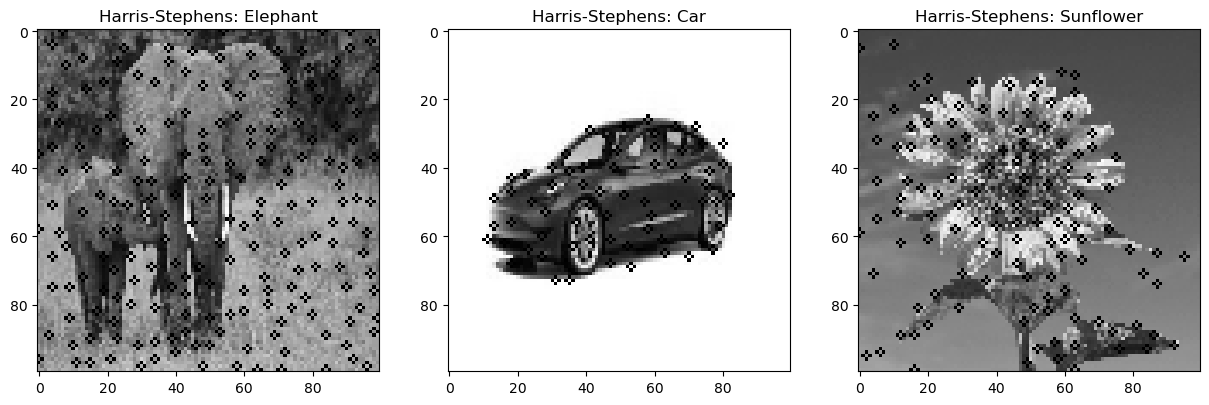

In [96]:
# Plot the grayscale images using Matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(theImage, cmap='gray')
plt.title("Harris-Stephens: Elephant")

plt.subplot(1, 3, 2)
plt.imshow(theImage2, cmap='gray')
plt.title("Harris-Stephens: Car")

plt.subplot(1, 3, 3)
plt.imshow(theImage3, cmap='gray')
plt.title("Harris-Stephens: Sunflower")

plt.show()

The above images are only 100x100. You can alter the above code to resize the images. I just wanted the circles to be obvious in the above images. For the circles I also used a radius and thickness of 100 which you can change. I also used a minimum threshold of 1 when selecting the keypoints. If you think this is too many circles, you can adjust the second parameter of the strongestKeypoints function which stores the minimum threshold. 

In [97]:
######## Section 1.6 - Different corner strength function #######

def ComputeCornerStrengthAlternative(harrisMatrices, height, width):
    # For storing current index of row and column
    i = 0
    j = 0
    
    
    # List for storing the corner strength of every pixel
    #cornerStrengths = []
    cornerStrengths = np.zeros((height, width))
    
    # Loops through every matrix
    for matrix in harrisMatrices:
        # Gets eivenvalues of matrix
        eigenValues = np.linalg.eigvals(matrix);
        
        # Corner strength formula. Take minimum of eigenValues
        cornerStrength = min(eigenValues);
  
        # Storing the corner strength of each pixel
        cornerStrengths[i][j] = cornerStrength
        
        # Incrementing the index of the row
        i = i + 1
        
        # If reached end of row, begin on next row
        if i == width:
            i = 0
            j = j + 1
        
    
    return cornerStrengths

In [98]:
# Read in the image
theImage4 = cv2.imread("harris_elephant.jpeg")

# Convert image to grayscale
theImage4 = cv2.cvtColor(theImage4, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage4 = cv2.resize(theImage4, (100, 100))

# Get image height and width
height4, width4 = theImage4.shape[:2]

# Get the keypoints
harrisMatrices4 = ComputeHarrisMatrix(theImage4)
cornerStrengths4 = ComputeCornerStrengthAlternative(harrisMatrices4, height4, width4)
strongestKeypoints4 = SelectStrongestKeypoints(cornerStrengths4)



# Read in the image
theImage5 = cv2.imread("harris_car.jpeg")

# Convert image to grayscale
theImage5 = cv2.cvtColor(theImage5, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage5 = cv2.resize(theImage5, (100, 100))

# Get image height and width
height5, width5 = theImage5.shape[:2]

# Get the keypoints
harrisMatrices5 = ComputeHarrisMatrix(theImage5)
cornerStrengths5 = ComputeCornerStrengthAlternative(harrisMatrices5, height5, width5)
strongestKeypoints5 = SelectStrongestKeypoints(cornerStrengths5)



# Read in the image
theImage6 = cv2.imread("harris_sunflower.jpg")

# Convert image to grayscale
theImage6 = cv2.cvtColor(theImage6, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage6 = cv2.resize(theImage6, (100,100))

# Get image height and width
height6, width6 = theImage6.shape[:2]

# Get the keypoints
harrisMatrices6 = ComputeHarrisMatrix(theImage6)
cornerStrengths6 = ComputeCornerStrengthAlternative(harrisMatrices6, height6, width6)
strongestKeypoints6 = SelectStrongestKeypoints(cornerStrengths6)


In [99]:
# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints:
    x, y = keypoint
    cv2.circle(theImage, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints2:
    x, y = keypoint
    cv2.circle(theImage2, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints3:
    x, y = keypoint
    cv2.circle(theImage3, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints4:
    x, y = keypoint
    cv2.circle(theImage4, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints5:
    x, y = keypoint
    cv2.circle(theImage5, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints6:
    x, y = keypoint
    cv2.circle(theImage6, (x, y), radius=1, color=(0, 0, 255), thickness=1)
    

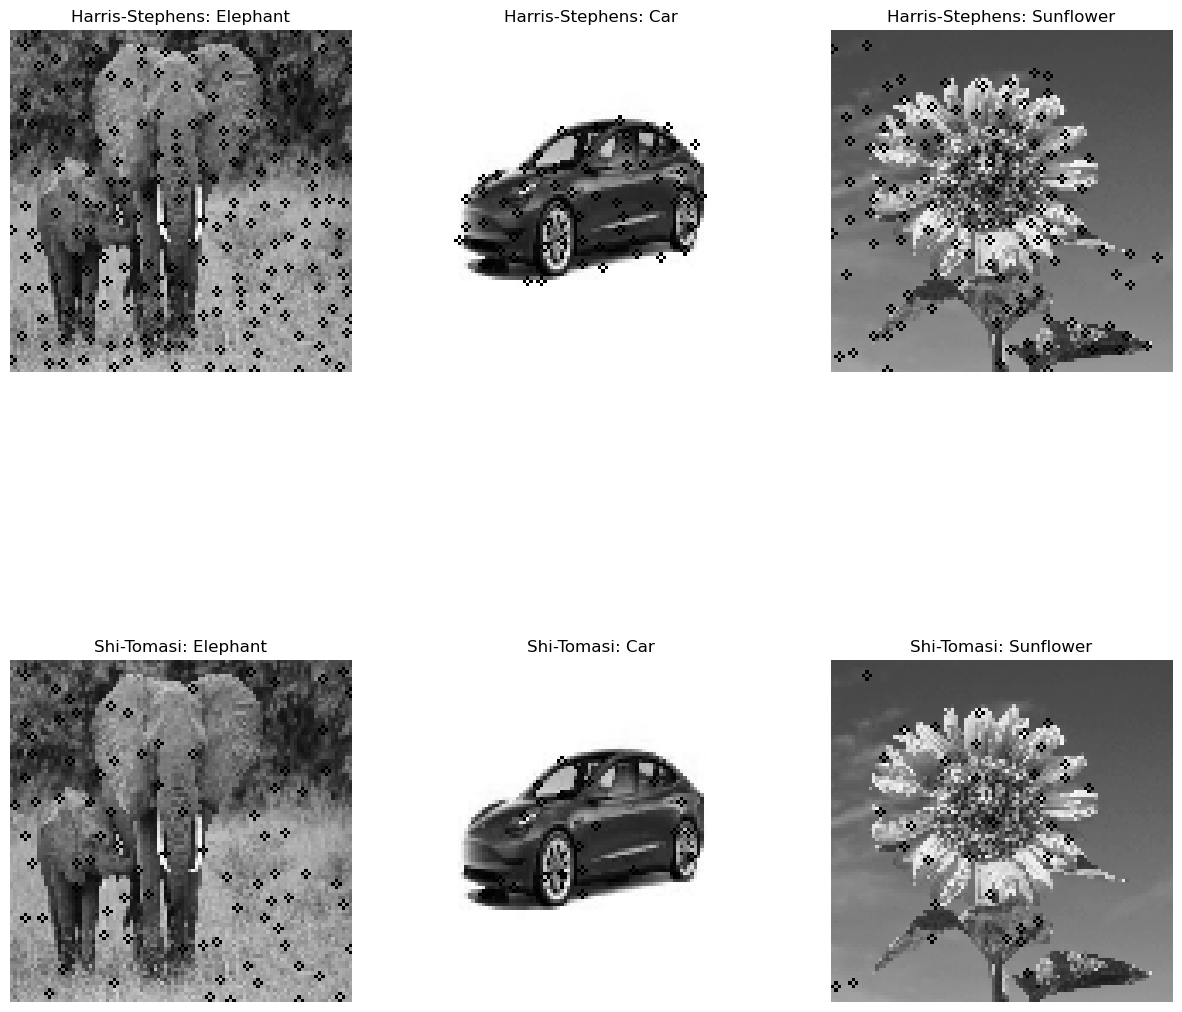

In [100]:
# Plot the grayscale images using Matplotlib
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(theImage, cmap='gray')
plt.title("Harris-Stephens: Elephant")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 2)
plt.imshow(theImage2, cmap='gray')
plt.title("Harris-Stephens: Car")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 3)
plt.imshow(theImage3, cmap='gray')
plt.title("Harris-Stephens: Sunflower")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 4)
plt.imshow(theImage4, cmap='gray')
plt.title("Shi-Tomasi: Elephant")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 5)
plt.imshow(theImage5, cmap='gray')
plt.title("Shi-Tomasi: Car")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 6)
plt.imshow(theImage6, cmap='gray')
plt.title("Shi-Tomasi: Sunflower")
plt.axis('off')  # Remove axes

plt.show()

The Shi-Tomasi has less key points than the Harris-Stephens. This is because the values of the keypoints for Shi-Tomasi are smaller than the values of the keypoints for Harris-Stephens. Thus, with a minimum threshold of 100 when selecting selecting keypoints, more of the key points in the 7x7 neighborhood for Shi-Tomasi will be under the threshold and that neighborhood will have no point at all. The points could be near indentical for both thresholding formulas if the minimum threshold is adjusted accordingly.

In [101]:
######## Section 1.7 - Visual inspection #######

# Read in the image
theImage7 = cv2.imread("elephant2.jpg")

# Convert image to grayscale
theImage7 = cv2.cvtColor(theImage7, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage7 = cv2.resize(theImage7, (100, 100))

# Get image height and width
height7, width7 = theImage7.shape[:2]

# Get the keypoints
harrisMatrices7 = ComputeHarrisMatrix(theImage7)
cornerStrengths7 = ComputeCornerStrength(harrisMatrices7, height7, width7)
strongestKeypoints7 = SelectStrongestKeypoints(cornerStrengths7)


# Read in the image
theImage8 = cv2.imread("car2.jpg")

# Convert image to grayscale
theImage8 = cv2.cvtColor(theImage8, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage8 = cv2.resize(theImage8, (100, 100))

# Get image height and width
height8, width8 = theImage8.shape[:2]

# Get the keypoints
harrisMatrices8 = ComputeHarrisMatrix(theImage8)
cornerStrengths8 = ComputeCornerStrength(harrisMatrices8, height8, width8)
strongestKeypoints8 = SelectStrongestKeypoints(cornerStrengths8)



# Read in the image
theImage9 = cv2.imread("sunflower2.jpeg")

# Convert image to grayscale
theImage9 = cv2.cvtColor(theImage9, cv2.COLOR_BGR2GRAY)

#Resize the image
theImage9 = cv2.resize(theImage9, (100, 100))

# Get image height and width
height9, width9 = theImage9.shape[:2]

# Get the keypoints
harrisMatrices9 = ComputeHarrisMatrix(theImage9)
cornerStrengths9 = ComputeCornerStrength(harrisMatrices9, height9, width9)
strongestKeypoints9 = SelectStrongestKeypoints(cornerStrengths9)

In [102]:
for keypoint in strongestKeypoints:
    x, y = keypoint
    cv2.circle(theImage, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints2:
    x, y = keypoint
    cv2.circle(theImage2, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints3:
    x, y = keypoint
    cv2.circle(theImage3, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints7:
    x, y = keypoint
    cv2.circle(theImage7, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints8:
    x, y = keypoint
    cv2.circle(theImage8, (x, y), radius=1, color=(0, 0, 255), thickness=1)

# Draw circles at keypoint locations for image
for keypoint in strongestKeypoints9:
    x, y = keypoint
    cv2.circle(theImage9, (x, y), radius=1, color=(0, 0, 255), thickness=1)

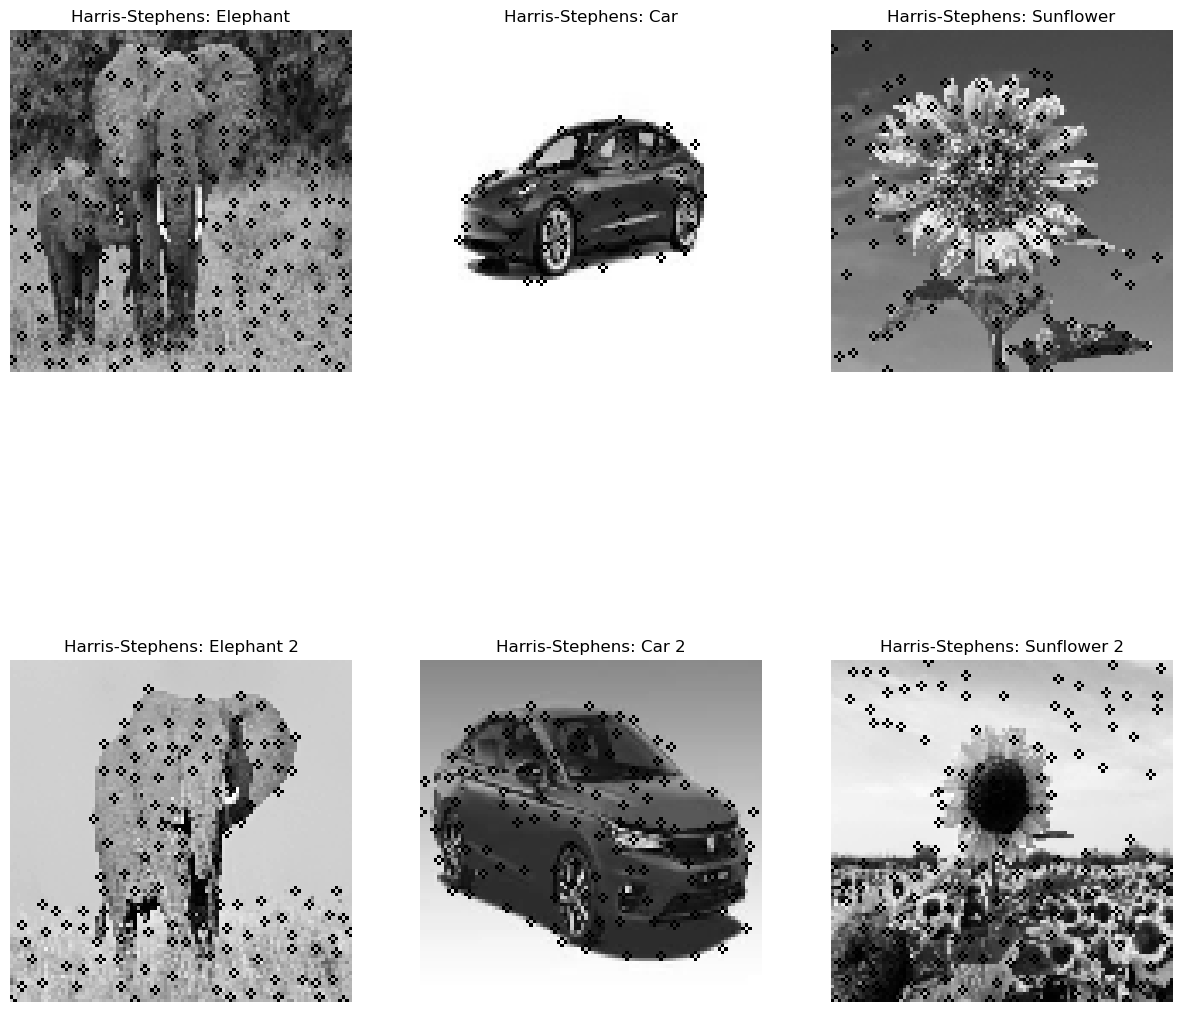

In [103]:
# Plot the grayscale images using Matplotlib
plt.figure(figsize=(15, 15))

plt.subplot(2, 3, 1)
plt.imshow(theImage, cmap='gray')
plt.title("Harris-Stephens: Elephant")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 2)
plt.imshow(theImage2, cmap='gray')
plt.title("Harris-Stephens: Car")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 3)
plt.imshow(theImage3, cmap='gray')
plt.title("Harris-Stephens: Sunflower")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 4)
plt.imshow(theImage7, cmap='gray')
plt.title("Harris-Stephens: Elephant 2")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 5)
plt.imshow(theImage8, cmap='gray')
plt.title("Harris-Stephens: Car 2")
plt.axis('off')  # Remove axes

plt.subplot(2, 3, 6)
plt.imshow(theImage9, cmap='gray')
plt.title("Harris-Stephens: Sunflower 2")
plt.axis('off')  # Remove axes

plt.show()

On the new pictures, similar features are being selected as keypoints. For the elephant pictures, the elephant and grass are being marked. For the car pictures, the car and its shadow are being marked. For the sunflower pictures, the sunflower(s) and shadows are being marked. This algorithm transfers well to other pictures outside of the project. 